## This is the basic load and clean stuff

In [1]:
# %load ~/dataviz/ExplorePy/clean-divvy-explore.py
import pandas as pd
import numpy as np
import datetime as dt
import pandas.api.types as pt
import pytz as pytz

from astral import LocationInfo
from astral.sun import sun
from astral.geocoder import add_locations, database, lookup

from dateutil import parser as du_pr

from pathlib import Path

db = database()

TZ=pytz.timezone('US/Central')
chi_town = lookup('Chicago', db)
print(chi_town)


rev = "5"

input_dir = '/mnt/d/DivvyDatasets'
input_divvy_basename = "divvy_trip_history_201909-202108"
input_divvy_base = input_dir + "/" + input_divvy_basename
input_divvy_raw = input_divvy_base + ".csv"
input_divvy_rev = input_dir + "/rev" + rev + "-" + input_divvy_basename + ".csv"
input_chitemp = input_dir + "/" + "ChicagoTemperature.csv"


#
#  returns true if the rev file is already present
#
def rev_file_exists():
  path = Path(input_divvy_rev)
  return path.is_file()




def update_dow_to_category(df):
  #
  # we need to get the dow properly set
  #
  cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

  cats_type = pt.CategoricalDtype(categories=cats, ordered=True)
  df['day_of_week'] = df['day_of_week'].astype(cats_type)

  return df




def update_start_cat_to_category(df):
  cats = ['AM_EARLY', 'AM_RUSH', 'AM_MID',
            'LUNCH',
            'PM_EARLY', 'PM_RUSH', 'PM_EVENING', 'PM_LATE']

  cats_type = pt.CategoricalDtype(categories=cats, ordered=True)
  df['start_cat'] = df['start_cat'].astype(cats_type)

  return df



#
# loads and returns the rev file as a data frame. It handles
#   the need to specify some column types
#
#  filename : the filename to load
#
def load_divvy_dataframe(filename):
  print("Loading " + filename)
  # so need to set the type on a couple of columns
  col_names = pd.read_csv(filename, nrows=0).columns

  types_dict = { 'ride_id': str, 
    'start_station_id': str,
    'end_station_id': str,
    'avg_temperature_celsius': float,
    'avg_temperature_fahrenheit': float,
    'duration': float,
    'start_lat': float,
    'start_lng': float,
    'end_lat': float,
    'end_lng': float,
    'avg_rain_intensity_mm/hour': float,
    'avg_wind_speed': float,
    'max_wind_speed': float,
    'total_solar_radiation': int,
    'is_dark': bool
    }
  types_dict.update({col: str for col in col_names if col not in types_dict})

  date_cols=['started_at','ended_at','date']

  df = pd.read_csv(filename, dtype=types_dict, parse_dates=date_cols)

  if 'start_time' in df:
    print("Converting start_time")
    df['start_time'] = df['start_time'].apply(lambda x: dt.datetime.strptime(x, "%H:%M:%S"))

  return df



def yrmo(year, month):
    return "{}-{}".format(year, month)




def calc_duration_in_minutes(started_at, ended_at):
    diff = ended_at - started_at
    return diff.total_seconds() / 60




#
# load the chicago temperature into a data frame
#
def load_temperature_dataframe():
  print("Loading " + input_chitemp)
  df = pd.read_csv(input_chitemp)

  print("Converting date")
  df['date'] = df['date'].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d"))

  return df




def add_start_time(started_at):
    return started_at.time()




def add_start_cat(started_at):
  start_time = started_at.time()
  time_new_day = dt.time(00,00)
  time_am_rush_start = dt.time(7,00)
  time_am_rush_end = dt.time(9,00)

  time_lunch_start = dt.time(11,30)
  time_lunch_end = dt.time(13,00)

  time_pm_rush_start = dt.time(15,30)
  time_pm_rush_end = dt.time(19,00)

  time_evening_end = dt.time(23,00)


  if start_time >= time_new_day and start_time < time_am_rush_start:
    return 'AM_EARLY'

  if start_time >= time_am_rush_start and start_time < time_am_rush_end:
    return 'AM_RUSH'

  if start_time >= time_am_rush_end and start_time < time_lunch_start:
    return 'AM_MID'

  if start_time >= time_lunch_start and start_time < time_lunch_end:
    return 'LUNCH'

  # slight change on Chi rush from 15:00 to 15:30
  if start_time >= time_lunch_end and start_time < time_pm_rush_start:
    return 'PM_EARLY'

  if start_time >= time_pm_rush_start and start_time < time_pm_rush_end:
    return 'PM_RUSH'

  if start_time >= time_pm_rush_end and start_time < time_evening_end:
    return 'PM_EVENING'

  return 'PM_LATE'




def add_is_dark(started_at):
  st = started_at.replace(tzinfo=TZ)
  chk = sun(chi_town.observer, date=st, tzinfo=chi_town.timezone)
  return st >= chk['dusk'] or st <= chk['dawn']



#
# handles loading and processing the divvy raw data by
#   adding columns, removing bad data, etc.
#
def process_raw_divvy(filename):
  df_divvy = load_divvy_dataframe(filename)

  print("Creating additional columns")
  data = pd.Series(df_divvy.apply(lambda x: [
                    add_start_time(x['started_at']),
                    add_is_dark(x['started_at']),
                    yrmo(x['year'], x['month']),
                    calc_duration_in_minutes(x['started_at'], x['ended_at']),
                    add_start_cat(x['started_at'])
                  ], axis = 1))

  new_df = pd.DataFrame(data.tolist(),
                        data.index, 
                        columns=['start_time','is_dark','yrmo','duration','start_cat'])

  df_divvy = df_divvy.merge(new_df, left_index=True, right_index=True)


  # #
  # # add a simplistic time element
  # #
  # print("Adding start_time")
  # df_divvy['start_time'] = df_divvy.apply(lambda row: add_start_time(row['started_at']), axis = 1)

  # print("Adding start_cat")
  # df_divvy['start_cat'] = df_divvy.apply(lambda row: add_start_cat(row['start_time']), axis = 1)

  # #
  # # is it dark
  # #
  # print("Adding is_dark")
  # df_divvy['is_dark'] = df_divvy.apply(lambda row: add_is_dark(row['started_at']), axis = 1)


  # #
  # # add a year-month column to the divvy dataframe
  # #  this uses a function with the row; it is not
  # #  the absolute fastest way
  # #
  # print("Adding year-month as yrmo")
  # df_divvy['yrmo'] = df_divvy.apply(lambda row: yrmo(row['year'], row['month']),
  #                                     axis = 1)

  # #
  # # we also want a duration to be calculated
  # #
  # print("Adding duration")
  # df_divvy['duration'] = df_divvy.apply(lambda row: calc_duration_in_minutes(row['started_at'],
  #                                                     row['ended_at']),
  #                                     axis = 1)

  #
  # add the temperature
  #
  df_chitemp = load_temperature_dataframe()

  print("Merging in temperature")
  df_divvy = pd.merge(df_divvy, df_chitemp, on="date")
  print(df_divvy.shape)
  print(df_divvy.head())
  # print(df_divvy.loc[df_divvy['date'] == '2020-02-21']) # 2020-02-21 was missing in org. temp

  # print(df_divvy[['ride_id','member_casual','date','duration','yrmo','avg_temperature_fahrenheit','start_time','start_cat']])

  #
  # clean the dataframe to remove invalid durations
  #   which are really only (about) < 1 minute, or > 12 hours
  #
  print("Removing invalid durations")
  df_divvy = df_divvy[(df_divvy.duration >= 1.2) & (df_divvy.duration < 60 * 12)]
  # print(df_divvy.shape)

  df_divvy = update_dow_to_category(df_divvy)
  df_divvy = update_start_cat_to_category(df_divvy)

  #
  # drop some bogus columns
  #
  print("Dropping columns")
  df_divvy.drop(df_divvy.columns[[0,-1]], axis=1, inplace=True)

  return df_divvy




#
# writes the dataframe to the specified filename
#
def save_dataframe(df, filename):
  print("Saving dataframe to " + filename)
  df_out = df.copy()
  df_out['date'] = df_out['date'].map(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
  df_out.to_csv(filename, index=False, date_format="%Y-%m-%d %H:%M:%S")


#
# load the divvy csv into a data frame
#


if rev_file_exists():
  df_divvy = load_divvy_dataframe(input_divvy_rev)
  df_divvy = update_dow_to_category(df_divvy)
  df_divvy = update_start_cat_to_category(df_divvy)
else:
  df_divvy = process_raw_divvy(input_divvy_raw)
  save_dataframe(df_divvy, input_divvy_rev)

print(df_divvy)
df_divvy.info()









#
# btw, can just pass the row and let the function figure it out
#
#def procone(row):
#    print(row['date'])
#    return 0
#df_divvy.apply(lambda row: procone(row), axis = 1)







LocationInfo(name='Chicago', region='USA', timezone='US/Central', latitude=41.833333333333336, longitude=-87.68333333333334)
Loading /mnt/d/DivvyDatasets/rev5-divvy_trip_history_201909-202108.csv
Converting start_time
              ID     ...1           ride_id rideable_type          started_at  \
0        1147482  8267501          24710636   docked_bike 2019-09-01 00:00:15   
1        1147483  8267502          24710637   docked_bike 2019-09-01 00:00:48   
2        1147484  8267503          24710638   docked_bike 2019-09-01 00:01:13   
3        1147485  8267504          24710639   docked_bike 2019-09-01 00:01:34   
4        1147486  8267505          24710640   docked_bike 2019-09-01 00:03:29   
...          ...      ...               ...           ...                 ...   
8190302  9464757  6162300  98EAC61BBAAF73C9  classic_bike 2021-08-31 07:46:16   
8190303  9464758  6162336  B060D2DF6AC0D65B  classic_bike 2021-08-31 17:57:04   
8190304  9464759  6162481  D22E7B3E5C0D162E  classic_

## Look at the average duration by rider type & day of week
### average duration by day of week for rider types

In [2]:
type(df_divvy['duration'])

pandas.core.series.Series

In [3]:
df_divvy.info()
df_divvy.shape

df_rider_by_dow = df_divvy.groupby(['member_casual','day_of_week']).agg(mean_time = ('duration', 'mean')).round(2)
df_rider_by_dow

df_rider_by_dow.sort_values(by=['member_casual','day_of_week'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190307 entries, 0 to 8190306
Data columns (total 32 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   ID                          object        
 1   ...1                        object        
 2   ride_id                     object        
 3   rideable_type               object        
 4   started_at                  datetime64[ns]
 5   ended_at                    datetime64[ns]
 6   start_station_name          object        
 7   start_station_id            object        
 8   end_station_name            object        
 9   end_station_id              object        
 10  start_lat                   float64       
 11  start_lng                   float64       
 12  end_lat                     float64       
 13  end_lng                     float64       
 14  member_casual               object        
 15  date                        datetime64[ns]
 16  month             

mean_time
member_casual day_of_week           
casual        Monday           31.34
              Tuesday          28.65
              Wednesday        28.07
              Thursday         27.94
              Friday           29.24
              Saturday         33.72
              Sunday           35.30
member        Monday           13.46
              Tuesday          13.32
              Wednesday        13.40
              Thursday         13.38
              Friday           13.73
              Saturday         15.98
              Sunday           16.14

### Now we want to plot

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#### bar plot of Duration by Rider Type and Day of Week

<AxesSubplot:xlabel='day_of_week'>

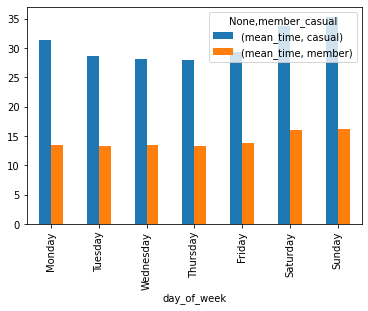

In [5]:
df_rider_by_dow.unstack('member_casual').plot(kind='bar')

<AxesSubplot:xlabel='day_of_week', ylabel='mean_time'>

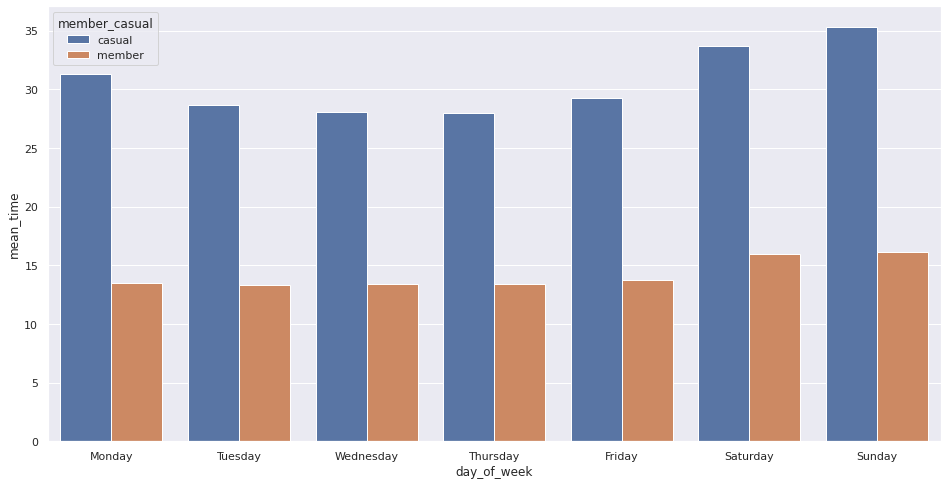

In [6]:
df_rider_by_dow.reset_index(inplace=True)
sns.set(rc={"figure.figsize":(16,8)})
sns.barplot(data=df_rider_by_dow, x="day_of_week", y="mean_time", hue="member_casual")

## Look at the number of riders by type and day of week
### grouping

In [7]:
df_rider_by_dow = df_divvy.groupby(['member_casual','day_of_week']).agg(num_rides = ('ID', 'count'))
df_rider_by_dow

#df_rider_by_dow['day_of_week'] = df_rider_by_dow['day_of_week'].astype(cats_type)
df_rider_by_dow.sort_values(by=['member_casual','day_of_week'])

num_rides
member_casual day_of_week           
casual        Monday          368155
              Tuesday         347995
              Wednesday       350736
              Thursday        371177
              Friday          467382
              Saturday        734235
              Sunday          628519
member        Monday          706423
              Tuesday         753748
              Wednesday       749612
              Thursday        742154
              Friday          727633
              Saturday        658274
              Sunday          584264

### plot of Number of Rids by Rider Type and Day of Week

<AxesSubplot:xlabel='day_of_week'>

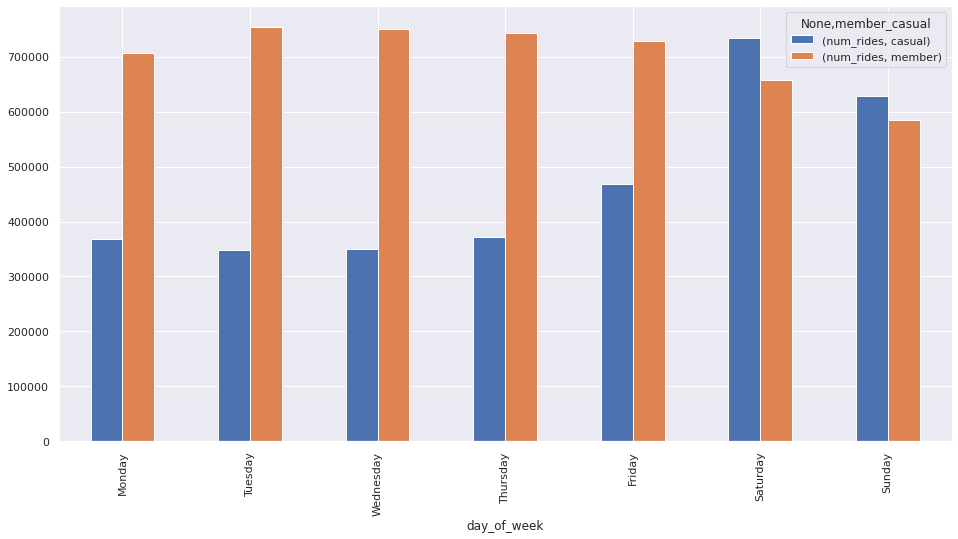

In [8]:
df_rider_by_dow.unstack('member_casual').plot(kind='bar')

<AxesSubplot:xlabel='day_of_week', ylabel='num_rides'>

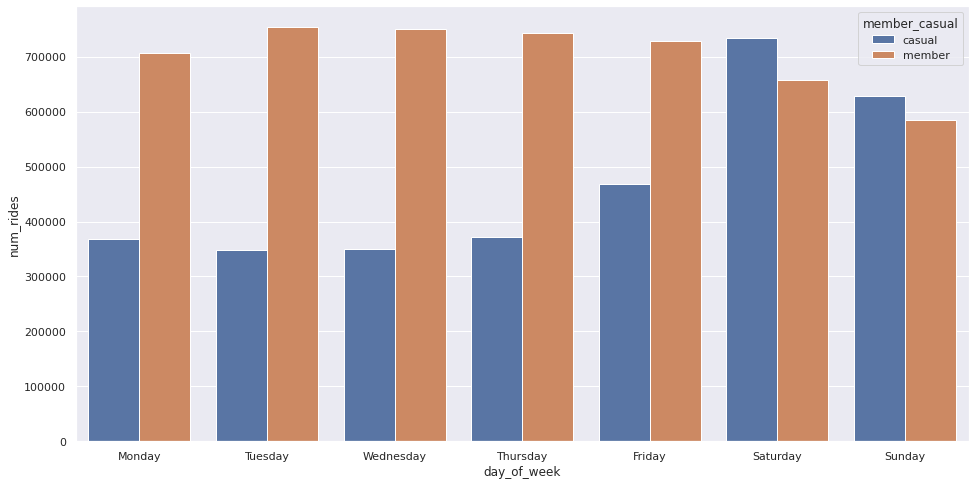

In [9]:
df_rider_by_dow.reset_index(inplace=True)
sns.set(rc={"figure.figsize":(16,8)})
sns.barplot(data=df_rider_by_dow, x="day_of_week", y="num_rides", hue="member_casual")

In [10]:
df_member_by_yr_dow = df_divvy[df_divvy['member_casual'] == 'member'].groupby(['year','day_of_week']).agg(mean_time = ('duration', 'mean')).round(2)
df_casual_by_yr_dow = df_divvy[df_divvy['member_casual'] == 'casual'].groupby(['year','day_of_week']).agg(mean_time = ('duration', 'mean')).round(2)

<AxesSubplot:title={'center':'Member Rider mean time by year and day of week'}, xlabel='day_of_week'>

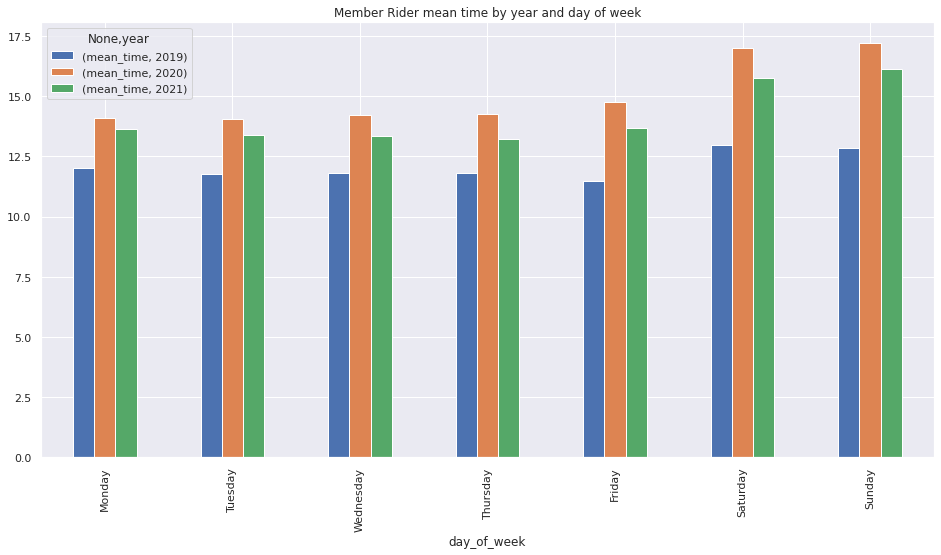

In [11]:
df_member_by_yr_dow.unstack('year').plot(kind='bar', title='Member Rider mean time by year and day of week')

<AxesSubplot:title={'center':'Casual Rider mean time by year and day of week'}, xlabel='day_of_week'>

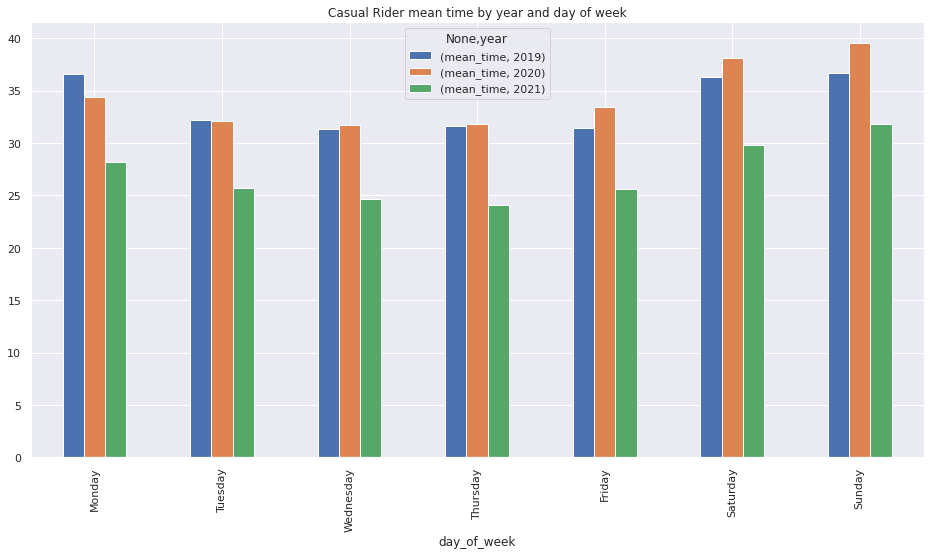

In [12]:
df_casual_by_yr_dow.unstack('year').plot(kind='bar', title='Casual Rider mean time by year and day of week')

In [13]:
df_rider_by_yrmo = df_divvy.groupby(['member_casual','yrmo']).agg(mean_time = ('duration', 'mean')).round(2)

<AxesSubplot:title={'center':'Rider mean time by yrmo'}, xlabel='yrmo'>

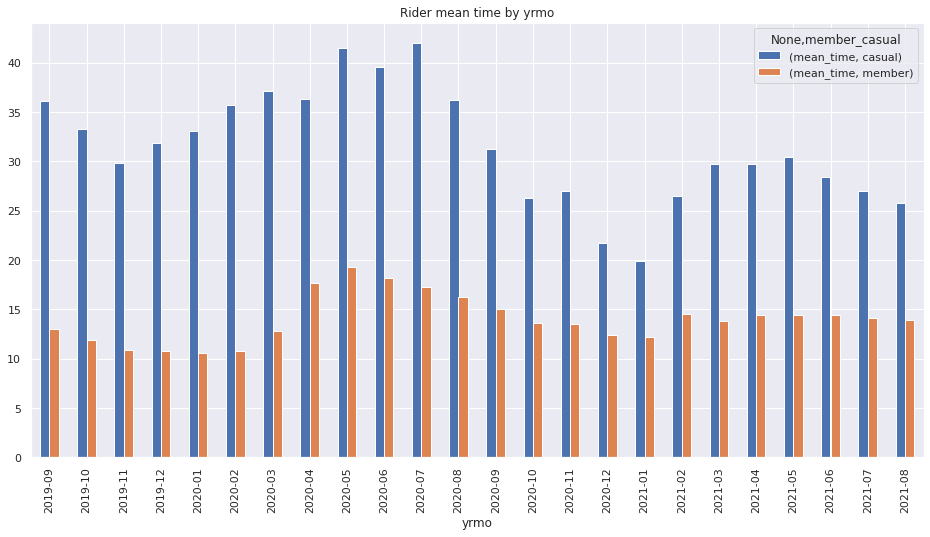

In [14]:
df_rider_by_yrmo.unstack('member_casual').plot(kind='bar', title='Rider mean time by yrmo')

<AxesSubplot:title={'center':'Rider count by yrmo'}, xlabel='yrmo'>

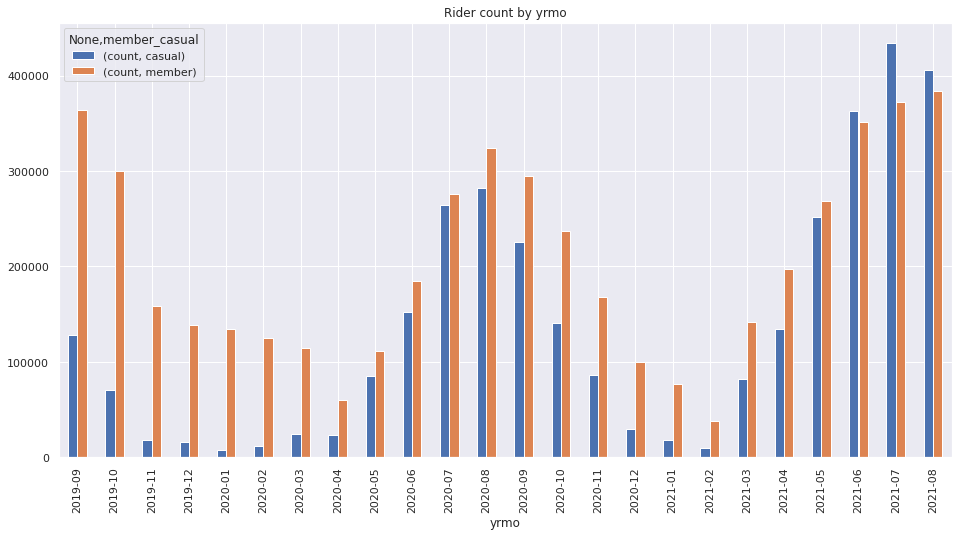

In [15]:
df_rider_count_by_yrmo = df_divvy.groupby(['member_casual','yrmo']).agg(count = ('ID', 'count'))
df_rider_count_by_yrmo.unstack('member_casual').plot(kind='bar', title='Rider count by yrmo')

<AxesSubplot:title={'center':'Rider count by yrmo'}, xlabel='yrmo'>

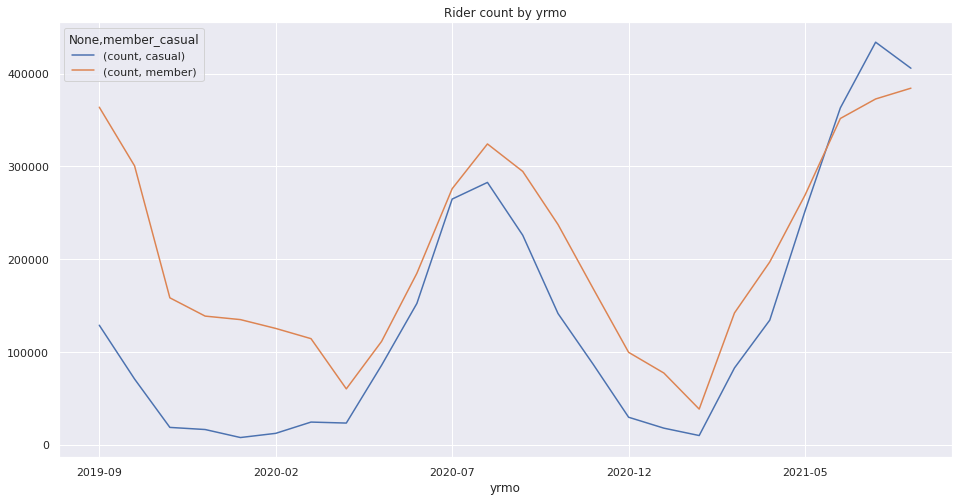

In [16]:
df_rider_count_by_yrmo.unstack('member_casual').plot(kind='line', title='Rider count by yrmo')

## Let's look at starting in the dark by rider

<AxesSubplot:title={'center':'Rider count by starting in the dark'}, xlabel='is_dark'>

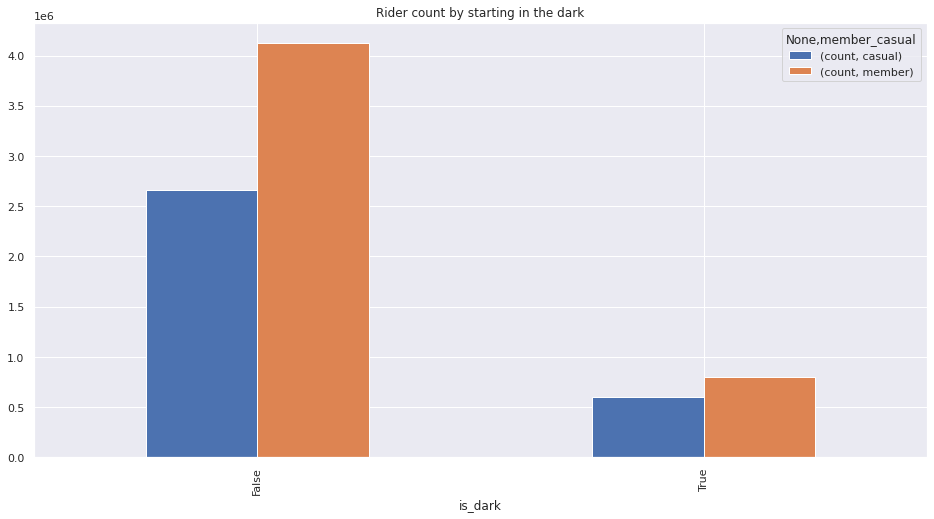

In [17]:
df_rider_count_by_is_dark = df_divvy.groupby(['member_casual','is_dark']).agg(count = ('ID', 'count'))
df_rider_count_by_is_dark.unstack('member_casual').plot(kind='bar', title='Rider count by starting in the dark')

<AxesSubplot:xlabel='member_casual'>

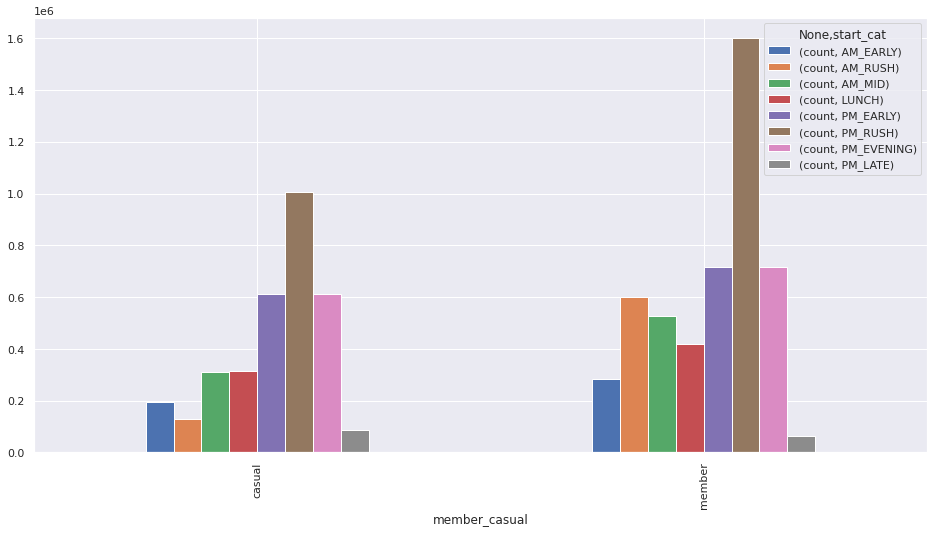

In [18]:
df_rider_by_time = df_divvy.groupby(['member_casual','start_cat']).agg(count = ('ID', 'count'))
df_rider_by_time.unstack('start_cat').plot(kind='bar')

In [19]:
weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday']
weekends = ['Saturday','Sunday']
weekday_riders = df_divvy[df_divvy.day_of_week.isin(weekdays)]
weekend_riders = df_divvy[df_divvy.day_of_week.isin(weekends)]

In [20]:
weekday_riders.shape
weekend_riders.shape

(2605292, 32)

<AxesSubplot:title={'center':'Weekday times'}, xlabel='member_casual'>

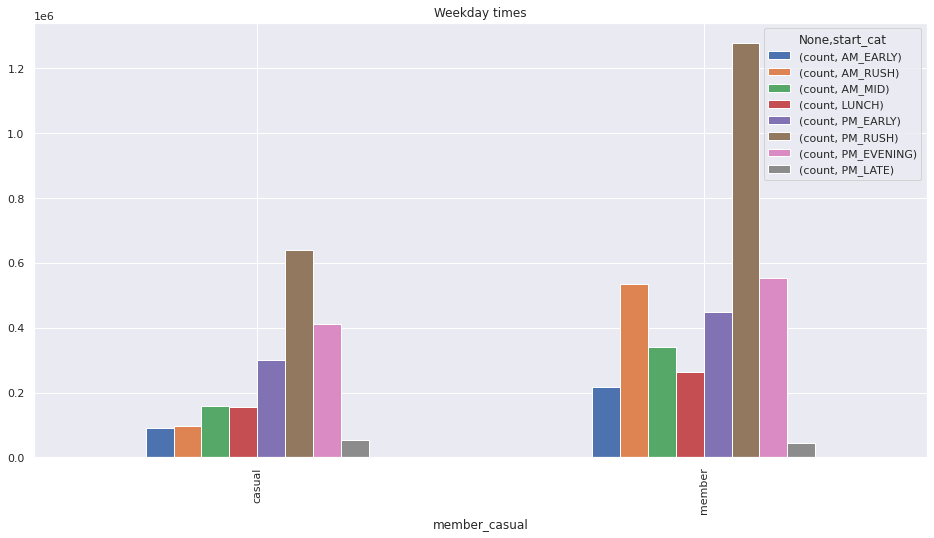

In [36]:
df_rider_by_time_weekday = weekday_riders.groupby(['member_casual','start_cat']).agg(count = ('ID', 'count'))

df_rider_by_time_weekday.unstack('start_cat').plot(kind='bar', title="Weekday times")

In [37]:
df_rider_by_time_weekday.to_csv(date_format="%Y-%m-%d %H:%M:%S")

'member_casual,start_cat,count\ncasual,AM_EARLY,90397\ncasual,AM_RUSH,95959\ncasual,AM_MID,158997\ncasual,LUNCH,154696\ncasual,PM_EARLY,301750\ncasual,PM_RUSH,639227\ncasual,PM_EVENING,410235\ncasual,PM_LATE,54184\nmember,AM_EARLY,217593\nmember,AM_RUSH,535107\nmember,AM_MID,341281\nmember,LUNCH,263658\nmember,PM_EARLY,449115\nmember,PM_RUSH,1276850\nmember,PM_EVENING,552931\nmember,PM_LATE,43035\n'

<AxesSubplot:title={'center':'Weekend times'}, xlabel='member_casual'>

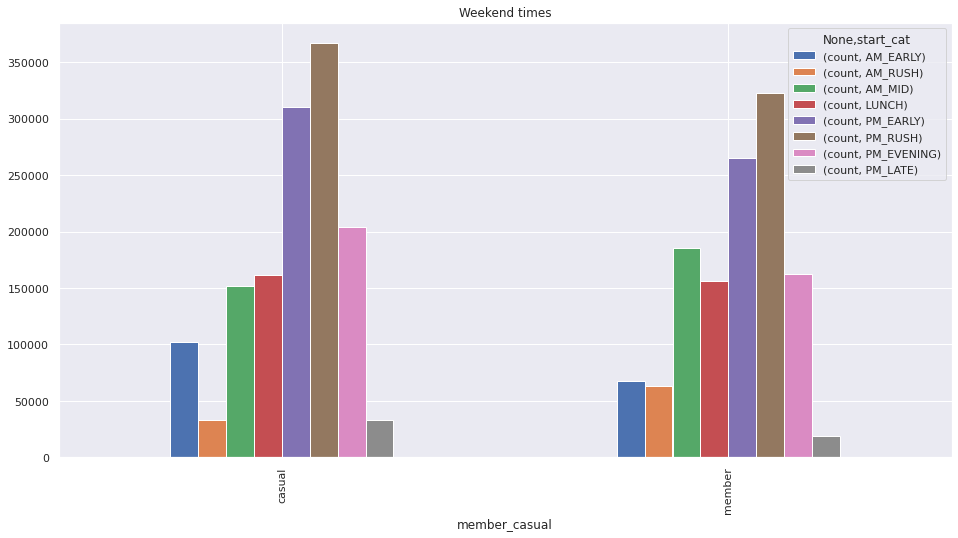

In [22]:
df_rider_by_time_weekend = weekend_riders.groupby(['member_casual','start_cat']).agg(count = ('ID', 'count'))
df_rider_by_time_weekend.unstack('start_cat').plot(kind='bar', title="Weekend times")

In [38]:
df_rider_by_time_weekend.to_csv()

'member_casual,start_cat,count\ncasual,AM_EARLY,102628\ncasual,AM_RUSH,33067\ncasual,AM_MID,151943\ncasual,LUNCH,161128\ncasual,PM_EARLY,310640\ncasual,PM_RUSH,366761\ncasual,PM_EVENING,203685\ncasual,PM_LATE,32902\nmember,AM_EARLY,67603\nmember,AM_RUSH,63518\nmember,AM_MID,185067\nmember,LUNCH,156002\nmember,PM_EARLY,265438\nmember,PM_RUSH,323101\nmember,PM_EVENING,162667\nmember,PM_LATE,19142\n'

## Starting stations -- member

<AxesSubplot:title={'center':'Starting Stations - Member'}, xlabel='start_station_name'>

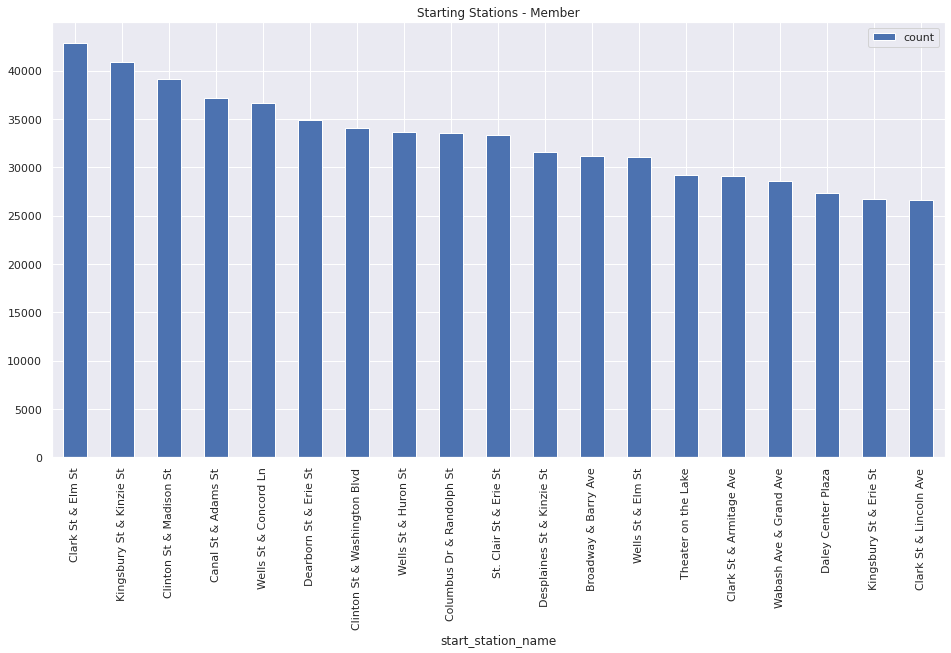

In [23]:
df_starting_member = df_divvy[df_divvy['member_casual']=='member'].groupby(['start_station_name']).agg(count=('ID','count'))
df_starting_member = df_starting_member.sort_values(by='count', ascending=False)
df_starting_member_top = df_starting_member.iloc[0:19]
df_starting_member_top.plot(kind='bar', title="Starting Stations - Member")


<AxesSubplot:title={'center':'Starting Stations Weekday - Member'}, xlabel='start_station_name'>

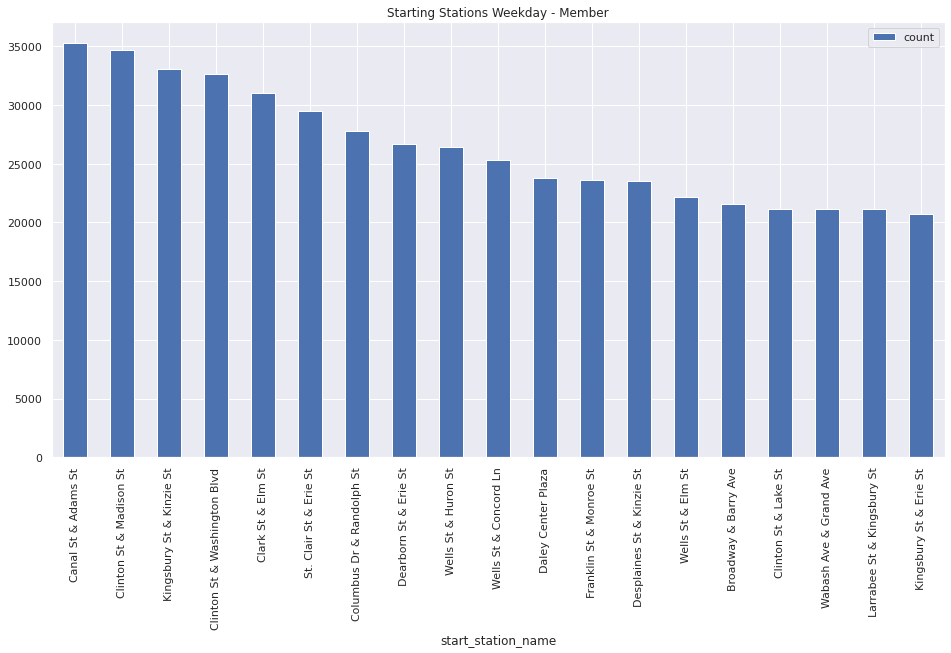

In [24]:

df_starting_member_weekday = weekday_riders[weekday_riders.member_casual=='member'].groupby(['start_station_name']).agg(count=('ID','count'))
df_starting_member_weekday = df_starting_member_weekday.sort_values(by='count', ascending=False)
df_starting_member_weekday_top = df_starting_member_weekday.iloc[0:19]
df_starting_member_weekday_top.plot(kind='bar', title="Starting Stations Weekday - Member")

In [25]:
from io import StringIO

In [26]:
output = StringIO()
df_starting_member_weekday_top.to_csv(output)
print(output.getvalue())

start_station_name,count
Canal St & Adams St,35273
Clinton St & Madison St,34717
Kingsbury St & Kinzie St,33102
Clinton St & Washington Blvd,32659
Clark St & Elm St,31045
St. Clair St & Erie St,29506
Columbus Dr & Randolph St,27767
Dearborn St & Erie St,26663
Wells St & Huron St,26391
Wells St & Concord Ln,25320
Daley Center Plaza,23766
Franklin St & Monroe St,23604
Desplaines St & Kinzie St,23542
Wells St & Elm St,22189
Broadway & Barry Ave,21582
Clinton St & Lake St,21176
Wabash Ave & Grand Ave,21165
Larrabee St & Kingsbury St,21155
Kingsbury St & Erie St,20737



<AxesSubplot:title={'center':'Starting Stations Weekend - Member'}, xlabel='start_station_name'>

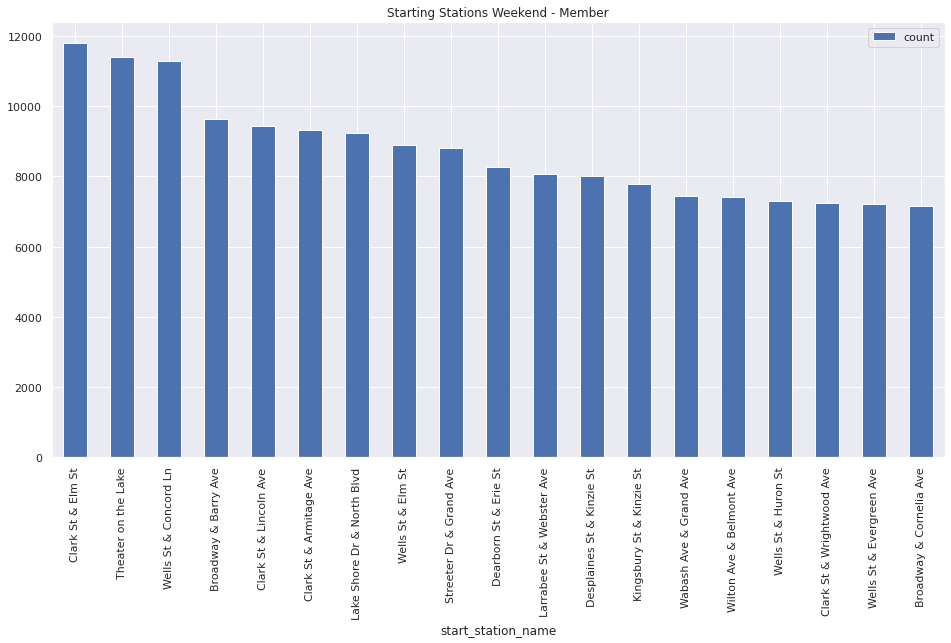

In [27]:
df_starting_member_weekend = weekend_riders[weekend_riders.member_casual=='member'].groupby(['start_station_name']).agg(count=('ID','count'))
df_starting_member_weekend = df_starting_member_weekend.sort_values(by='count', ascending=False)
df_starting_member_weekend_top = df_starting_member_weekend.iloc[0:19]
df_starting_member_weekend_top.plot(kind='bar', title="Starting Stations Weekend - Member")

In [28]:
output = StringIO()
df_starting_member_weekend_top.to_csv(output)
print(output.getvalue())

start_station_name,count
Clark St & Elm St,11804
Theater on the Lake,11412
Wells St & Concord Ln,11294
Broadway & Barry Ave,9624
Clark St & Lincoln Ave,9435
Clark St & Armitage Ave,9319
Lake Shore Dr & North Blvd,9245
Wells St & Elm St,8896
Streeter Dr & Grand Ave,8820
Dearborn St & Erie St,8260
Larrabee St & Webster Ave,8083
Desplaines St & Kinzie St,8021
Kingsbury St & Kinzie St,7777
Wabash Ave & Grand Ave,7440
Wilton Ave & Belmont Ave,7427
Wells St & Huron St,7309
Clark St & Wrightwood Ave,7251
Wells St & Evergreen Ave,7215
Broadway & Cornelia Ave,7171



## Starting Stations - casual

In [29]:
df_starting_casual = df_divvy[df_divvy['member_casual']=='casual'].groupby(['start_station_name']).agg(count=('ID','count'))
df_starting_casual = df_starting_casual.sort_values(by='count', ascending=False)
df_starting_casual_top = df_starting_casual.iloc[0:19]
df_starting_casual_top.head()


,count
start_station_name,
Streeter Dr & Grand Ave,87419
Lake Shore Dr & Monroe St,49004
Millennium Park,48207
Michigan Ave & Oak St,40109
Theater on the Lake,33949


In [30]:
df_starting_casual_weekday = weekday_riders[weekday_riders.member_casual=='casual'].groupby(['start_station_name']).agg(count=('ID','count'))
df_starting_casual_weekday = df_starting_casual_weekday.sort_values(by='count', ascending=False)
df_starting_casual_weekday_top = df_starting_casual_weekday.iloc[0:19]

output = StringIO()
df_starting_casual_weekday_top.to_csv(output)
print(output.getvalue())



start_station_name,count
Streeter Dr & Grand Ave,44736
Millennium Park,24934
Lake Shore Dr & Monroe St,24582
Michigan Ave & Oak St,20782
Shedd Aquarium,17311
Theater on the Lake,16601
Lake Shore Dr & North Blvd,15762
Indiana Ave & Roosevelt Rd,15170
Clark St & Elm St,13864
Wells St & Concord Ln,13838
Michigan Ave & Lake St,13401
Wabash Ave & Grand Ave,12614
Michigan Ave & Washington St,12559
Wells St & Elm St,12452
Clark St & Lincoln Ave,12262
Clark St & Armitage Ave,12175
Michigan Ave & 8th St,12008
Dusable Harbor,11541
Buckingham Fountain,11505



In [31]:
df_starting_casual_weekday_top.shape

(19, 1)

In [32]:
df_starting_casual_weekend = weekend_riders[weekend_riders.member_casual=='casual'].groupby(['start_station_name']).agg(count=('ID','count'))
df_starting_casual_weekend = df_starting_casual_weekend.sort_values(by='count', ascending=False)
df_starting_casual_weekend_top = df_starting_casual_weekend.iloc[0:19]

output = StringIO()
df_starting_casual_weekend_top.to_csv(output)
print(output.getvalue())

start_station_name,count
Streeter Dr & Grand Ave,42683
Lake Shore Dr & Monroe St,24422
Millennium Park,23273
Michigan Ave & Oak St,19327
Theater on the Lake,17348
Lake Shore Dr & North Blvd,14798
Shedd Aquarium,14373
Indiana Ave & Roosevelt Rd,12122
Clark St & Lincoln Ave,11290
Dusable Harbor,10879
Wells St & Concord Ln,10573
Clark St & Armitage Ave,10339
Wabash Ave & Grand Ave,10207
Michigan Ave & Washington St,10082
Michigan Ave & Lake St,9802
Clark St & Elm St,9795
Buckingham Fountain,9458
Michigan Ave & 8th St,9345
Fairbanks Ct & Grand Ave,8833

